Wikidata and Bandford low analysis


https://linkedwiki.com/query/wikidata_Country_populations_together_with_total_city_populations?lang=EN

and Benford law :
https://towardsdatascience.com/frawd-detection-using-benfords-law-python-code-9db8db474cf8


## Libraries

In [1]:
#import libraries
import pandas as pd
import numpy as np
import math

from collections import defaultdict

import sys
import math
import matplotlib.pyplot as plt
%matplotlib inline


## Data aquisition

In [2]:


from SPARQLWrapper import SPARQLWrapper, JSON
from SPARQLWrapper import SPARQLWrapper2

sparql = SPARQLWrapper("https://query.wikidata.org/sparql")

strSparqlSelect = ("""
PREFIX bd: <http://www.bigdata.com/rdf#>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wikibase: <http://wikiba.se/ontology#>

SELECT ?country ?countryLabel ?continentLabel ?population ?hdindex ?totalCityPopulation (?population / ?totalCityPopulation AS ?ratio) {
  ?country wdt:P1082 ?population .
  ?country wdt:P30  ?continent .
  ?continent wdt:P31 wd:Q5107 .
  ?country   wdt:P1081 ?hdindex
  
   FILTER NOT EXISTS {
    ?country wd:P1082/wdt:P585 ?hdi_date_ .
    FILTER (?hdi_date_ > ?hdi_date)
                     }
   FILTER NOT EXISTS {
    ?country wdt:P1081/wdt:P585 ?hdi_date_ .
    FILTER (?hdi_date_ > ?hdi_date)
                      }
 
  
  
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en" }
  {
    SELECT ?country (SUM(?cityPopulation) AS ?totalCityPopulation) WHERE {
      ?city wdt:P31 wd:Q515 .
      ?city wdt:P17 ?country .
      ?city wdt:P1082 ?cityPopulation .
      
    } GROUP BY ?country
  }
} ORDER BY ?ratio""")

sparql.setQuery(strSparqlSelect)
try:

  sparql.setReturnFormat(JSON)
  results = sparql.query().convert()
  # results = sparql.queryAndConvert()
  """
  # for testing
  for result in results["results"]["bindings"]:
      print(result)
  """

except Exception as e:
  print(e)

In [3]:

results["results"]["bindings"][0]

{'country': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q977'},
 'hdindex': {'datatype': 'http://www.w3.org/2001/XMLSchema#decimal',
  'type': 'literal',
  'value': '0.509'},
 'population': {'datatype': 'http://www.w3.org/2001/XMLSchema#decimal',
  'type': 'literal',
  'value': '956985'},
 'totalCityPopulation': {'datatype': 'http://www.w3.org/2001/XMLSchema#decimal',
  'type': 'literal',
  'value': '2863922'},
 'countryLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'Djibouti'},
 'continentLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'Africa'},
 'ratio': {'datatype': 'http://www.w3.org/2001/XMLSchema#decimal',
  'type': 'literal',
  'value': '0.33415190776843782757'}}

In [4]:
try:
    rawdata = [{"country" : x["countryLabel"]["value"],"continent" : x["continentLabel"]["value"],"totalCityPopulation" : round(float(x["totalCityPopulation"]["value"])), "population" : int(x["population"]["value"]), "ratio" : round(float(x["ratio"]["value"]),1)} for x in results["results"]["bindings"]]

except Exception as e:
  print(e)

rawdata[0]

{'country': 'Djibouti',
 'continent': 'Africa',
 'totalCityPopulation': 2863922,
 'population': 956985,
 'ratio': 0.3}

## A look at the data

In [5]:
maindata = pd.DataFrame(rawdata)
maindata.head()

,country,continent,totalCityPopulation,population,ratio
0,Djibouti,Africa,2863922,956985,0.3
1,São Tomé and Príncipe,Africa,391964,204327,0.5
2,New Zealand,Insular Oceania,7145560,5118700,0.7
3,United Arab Emirates,Asia,12009189,9890400,0.8
4,North Macedonia,Europe,2051544,1836713,0.9


In [6]:
# Provide the number of rows and columns in this dataset.
num_rows = maindata.shape[0] #Provide the number of rows in the dataset
num_cols = maindata.shape[1] #Provide the number of columns in the dataset
(num_rows,num_cols)

(198, 5)

In [7]:
# A set of column names that have no missing values.
no_nulls = set(maindata.columns[maindata.isnull().mean()==0])#Provide a set of columns with 0 missing values.
no_nulls

{'continent', 'country', 'population', 'ratio', 'totalCityPopulation'}

In [8]:
maindata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   country              198 non-null    object 
 1   continent            198 non-null    object 
 2   totalCityPopulation  198 non-null    int64  
 3   population           198 non-null    int64  
 4   ratio                198 non-null    float64
dtypes: float64(1), int64(2), object(2)
memory usage: 7.9+ KB


In [9]:
maindata.describe()

,totalCityPopulation,population,ratio
count,1.980000e+02,1.980000e+02,198.000000
mean,6.498452e+06,4.331579e+07,30.785859
std,1.611588e+07,1.468133e+08,172.604892
min,4.040000e+03,1.179200e+04,0.300000
25%,4.312645e+05,2.352194e+06,2.525000
50%,1.626932e+06,9.083447e+06,4.400000
75%,6.402425e+06,3.016312e+07,8.825000
max,1.467800e+08,1.443497e+09,1774.900000


### Analyse uniqunes of country data

In [10]:
maindata.nunique(axis=0)

country                187
continent                6
totalCityPopulation    187
population             188
ratio                  105
dtype: int64

In [11]:
# identification of duplicates among countries
maindata[maindata.duplicated(keep=False, subset=['country'])]

,country,continent,totalCityPopulation,population,ratio
25,Georgia,Europe,2196070,3717100,1.7
26,Georgia,Asia,2196070,3717100,1.7
32,Kazakhstan,Europe,9800394,18276500,1.9
33,Kazakhstan,Asia,9800394,18276500,1.9
39,Turkey,Europe,40725414,84680273,2.1
40,Turkey,Asia,40725414,84680273,2.1
59,Panama,South America,1479264,4098587,2.8
60,Panama,North America,1479264,4098587,2.8
64,Egypt,Africa,33411500,94798827,2.8
65,Egypt,Asia,33411500,94798827,2.8


Artificial duplicities are mainly due to country population overlaping over several continents. The amount of population is same for different continents, so we can take this value only once.

In [12]:
maindataunique = maindata.drop_duplicates(subset=['country'])

In [13]:
# control  of contry uniqueness
maindataunique[maindataunique.duplicated(keep=False, subset=['country'])]

,country,continent,totalCityPopulation,population,ratio


In [14]:
maindataunique.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187 entries, 0 to 197
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   country              187 non-null    object 
 1   continent            187 non-null    object 
 2   totalCityPopulation  187 non-null    int64  
 3   population           187 non-null    int64  
 4   ratio                187 non-null    float64
dtypes: float64(1), int64(2), object(2)
memory usage: 8.8+ KB


## A business look at the data quality and objective feasibility

Text(0.5, 1.0, 'Comparing population of the state with agregated city population ')

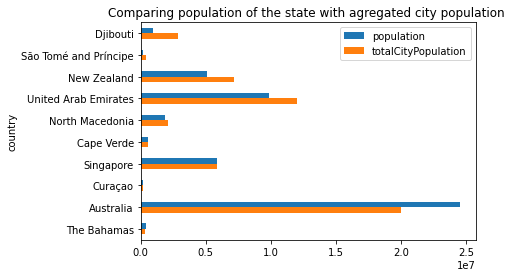

In [15]:
# pd.DataFrame(rawdata).set_index("country").head(10).plot.barh().invert_yaxis()
maindataunique[["country","population","totalCityPopulation"]].set_index("country").head(10).plot.barh().invert_yaxis()
plt.title("Comparing population of the state with agregated city population ")

In [16]:
# Let we analyse data quality, where agreation of city population exceeds totoal country population. This id due to the fact probablz, that 
# we have counted city citizens at Wikidata over overlaping cities - regions
maindataunique[maindataunique["ratio"]<1]

,country,continent,totalCityPopulation,population,ratio
0,Djibouti,Africa,2863922,956985,0.3
1,São Tomé and Príncipe,Africa,391964,204327,0.5
2,New Zealand,Insular Oceania,7145560,5118700,0.7
3,United Arab Emirates,Asia,12009189,9890400,0.8
4,North Macedonia,Europe,2051544,1836713,0.9


In [17]:
# If ratio eexceeds 10 we can face situation of very rural country or very low coverage of city poůpulation by Wikidata
maindataunique[maindataunique["ratio"]>100]

,country,continent,totalCityPopulation,population,ratio
191,Ukraine,Europe,365839,41588354,113.7
192,Portugal,Europe,83401,10347892,124.1
193,Palestinian territories,Asia,19197,4550000,237.0
194,Indonesia,Asia,841902,275439000,327.2
196,Iran,Asia,54178,86758304,1601.4
197,Philippines,Asia,61432,109035343,1774.9


## Bendford's law processing
using functions from https://towardsdatascience.com/frawd-detection-using-benfords-law-python-code-9db8db474cf8


In [18]:
str_population = "population"

In [19]:
# code from https://github.com/eleprocha/Benford-s-Law_python_code/blob/master/code
# https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test



#Load data from an excel file and set as variable the numeric column which it is about  to make the goodnsess of fit test
"""
def load_data(filename,var):
        df=pd.read_excel(filename)
        data=df[var]
        return df,data
"""
def load_data(df,var):
        data=df[var]
        return df,data




#we create a function which output is the final counts, and the frequency of each count as a
#percentage, are returned as lists to use in subsequent functions.
def count_first_digit(df,data_str):#TAKE AS AN ARGUMENT A STR-COLUMN NAME
    mask=df[data_str]>1.
    data=list(df[mask][data_str])
    for i in range(len(data)):
        while data[i]>10:
            data[i]=data[i]/10
    first_digits=[int(x) for x in sorted(data)]
    unique=(set(first_digits))#a list with unique values of first_digit list
    data_count=[]
    for i in unique:
        count=first_digits.count(i)
        data_count.append(count)
    total_count=sum(data_count)
    data_percentage=[(i/total_count)*100 for i in data_count]
    return  total_count,data_count, data_percentage
    
    # Benford's Law percentages for leading digits 1-9
BENFORD = [30.1, 17.6, 12.5, 9.7, 7.9, 6.7, 5.8, 5.1, 4.6]




def get_expected_counts(total_count):

    """Return list of expected Benford's Law counts for total sample count."""

    return [round(p * total_count / 100) for p in BENFORD]








def chi_square_test(data_count,expected_counts):

    """Return boolean on chi-square test (8 degrees of freedom & P-val=0.05)."""

    chi_square_stat = 0  # chi square test statistic

    for data, expected in zip(data_count,expected_counts):

        chi_square = math.pow(data - expected, 2)

        chi_square_stat += chi_square / expected

    print("\nChi-squared Test Statistic = {:.3f}".format(chi_square_stat))

    print("Critical value at a P-value of 0.05 is 15.51.")    

    return chi_square_stat < 15.51


#1st_bar_chart
def bar_chart(data_pct):

    """Make bar chart of observed vs expected 1st digit frequency in percent."""

    fig, ax = plt.subplots()



    index = [i + 1 for i in range(len(data_pct))]  # 1st digits for x-axis
# text for labels, title and ticks

    fig.canvas.set_window_title('Percentage First Digits')

    ax.set_title('Data vs. Benford Values', fontsize=15)

    ax.set_ylabel('Frequency (%)', fontsize=16)

    ax.set_xticks(index)

    ax.set_xticklabels(index, fontsize=14)



    # build bars    

    rects = ax.bar(index, data_pct, width=0.95, color='black', label='Data')



    # attach a text label above each bar displaying its height

    for rect in rects:

        height = rect.get_height()

        ax.text(rect.get_x() + rect.get_width()/2, height,

                '{:0.1f}'.format(height), ha='center', va='bottom', 

                fontsize=13)



    # plot Benford values as red dots

    ax.scatter(index, BENFORD, s=150, c='red', zorder=2, label='Benford')



    # Hide the right and top spines & add legend

    ax.spines['right'].set_visible(False)

    ax.spines['top'].set_visible(False)

    ax.legend(prop={'size':15}, frameon=False)

    

    plt.show()
    
    #2nd_bar_chart
    labels=list(data_pct)
    width = 0.35 
    x = np.arange(len(data_pct)) # the label locations
    width = 0.35  # the width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width, data_pct, width=0.95, color='black', label='Data')
    rects2 = ax.bar(x + width, BENFORD,width,label='Benford')
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Frequency (%)', fontsize=16)
    ax.set_title('Benford')
    ax.set_xticks(x)
    ax.legend()
    plt.show()





In [20]:
#specify the main() function and runs the program & prints some statistics.
def main(df,data_str):
    total_count,data_count, data_percentage = count_first_digit(df,data_str)

    expected_counts = get_expected_counts(total_count)

    print("\nobserved counts = {}".format(data_count))

    print("expected counts = {}".format(expected_counts), "\n")


    print("First Digit Probabilities:")




    for i in range(1, 10):

        print("{}: observed: {:.3f}  expected: {:.3f}".

              format(i, data_percentage[i - 1] / 100, BENFORD[i - 1] / 100))



    if chi_square_test(data_count, expected_counts):

        print("Observed distribution matches expected distribution.")

    else:

        print("Observed distribution does not match expected.", file=sys.stderr)       



    bar_chart(data_percentage)





observed counts = [56, 34, 20, 19, 19, 13, 6, 10, 10]
expected counts = [56, 33, 23, 18, 15, 13, 11, 10, 9] 

First Digit Probabilities:
1: observed: 0.299  expected: 0.301
2: observed: 0.182  expected: 0.176
3: observed: 0.107  expected: 0.125
4: observed: 0.102  expected: 0.097
5: observed: 0.102  expected: 0.079
6: observed: 0.070  expected: 0.067
7: observed: 0.032  expected: 0.058
8: observed: 0.053  expected: 0.051
9: observed: 0.053  expected: 0.046

Chi-squared Test Statistic = 3.928
Critical value at a P-value of 0.05 is 15.51.
Observed distribution matches expected distribution.


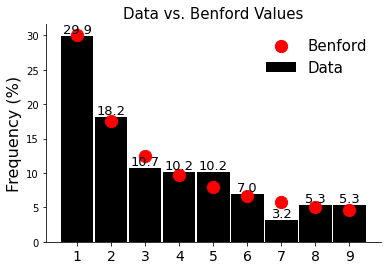

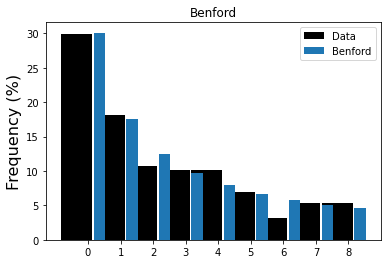

In [21]:
main(maindataunique,str_population)


observed counts = [63, 34, 20, 10, 16, 15, 10, 11, 8]
expected counts = [56, 33, 23, 18, 15, 13, 11, 10, 9] 

First Digit Probabilities:
1: observed: 0.337  expected: 0.301
2: observed: 0.182  expected: 0.176
3: observed: 0.107  expected: 0.125
4: observed: 0.053  expected: 0.097
5: observed: 0.086  expected: 0.079
6: observed: 0.080  expected: 0.067
7: observed: 0.053  expected: 0.058
8: observed: 0.059  expected: 0.051
9: observed: 0.043  expected: 0.046

Chi-squared Test Statistic = 5.529
Critical value at a P-value of 0.05 is 15.51.
Observed distribution matches expected distribution.


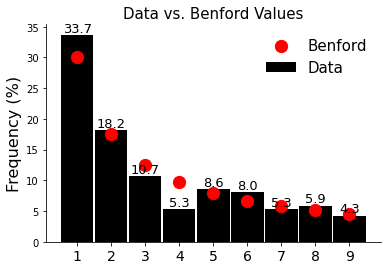

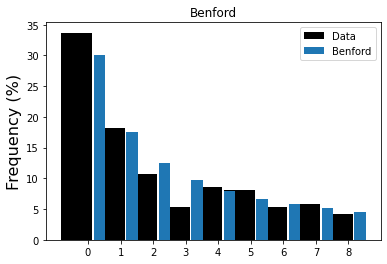

In [22]:
# Let we test the same for city population
main(maindataunique,"totalCityPopulation")

# Let we check whether data collection fulfil Bendford properties via multiplying any constant

0.13436424411240122
random multiplying factor constant for all population data  = 0.13436424411240122 


observed counts = [60, 31, 23, 15, 13, 15, 15, 10, 5]
expected counts = [56, 33, 23, 18, 15, 13, 11, 10, 9] 

First Digit Probabilities:
1: observed: 0.321  expected: 0.301
2: observed: 0.166  expected: 0.176
3: observed: 0.123  expected: 0.125
4: observed: 0.080  expected: 0.097
5: observed: 0.070  expected: 0.079
6: observed: 0.080  expected: 0.067
7: observed: 0.080  expected: 0.058
8: observed: 0.053  expected: 0.051
9: observed: 0.027  expected: 0.046

Chi-squared Test Statistic = 4.714
Critical value at a P-value of 0.05 is 15.51.
Observed distribution matches expected distribution.


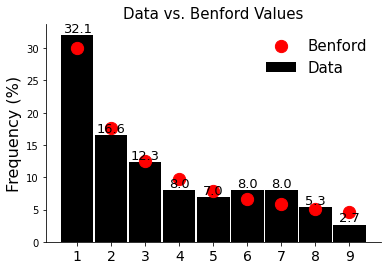

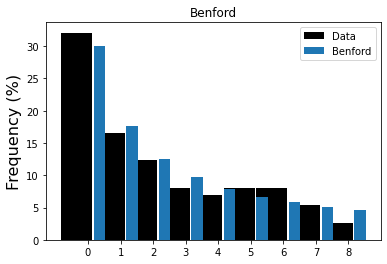

0.8474337369372327
random multiplying factor constant for all population data  = 0.8474337369372327 


observed counts = [48, 30, 23, 24, 14, 6, 12, 16, 14]
expected counts = [56, 33, 23, 18, 15, 13, 11, 10, 9] 

First Digit Probabilities:
1: observed: 0.257  expected: 0.301
2: observed: 0.160  expected: 0.176
3: observed: 0.123  expected: 0.125
4: observed: 0.128  expected: 0.097
5: observed: 0.075  expected: 0.079
6: observed: 0.032  expected: 0.067
7: observed: 0.064  expected: 0.058
8: observed: 0.086  expected: 0.051
9: observed: 0.075  expected: 0.046

Chi-squared Test Statistic = 13.720
Critical value at a P-value of 0.05 is 15.51.
Observed distribution matches expected distribution.


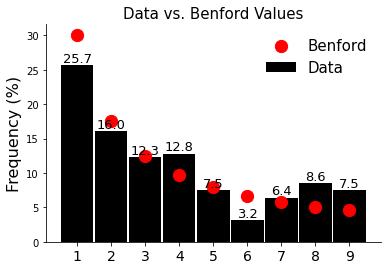

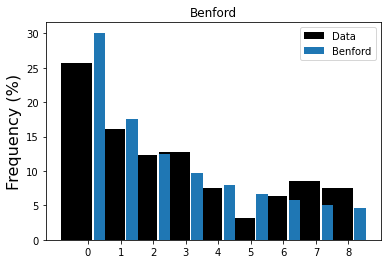

0.763774618976614
random multiplying factor constant for all population data  = 0.763774618976614 


observed counts = [45, 32, 26, 20, 12, 12, 14, 16, 10]
expected counts = [56, 33, 23, 18, 15, 13, 11, 10, 9] 

First Digit Probabilities:
1: observed: 0.241  expected: 0.301
2: observed: 0.171  expected: 0.176
3: observed: 0.139  expected: 0.125
4: observed: 0.107  expected: 0.097
5: observed: 0.064  expected: 0.079
6: observed: 0.064  expected: 0.067
7: observed: 0.075  expected: 0.058
8: observed: 0.086  expected: 0.051
9: observed: 0.053  expected: 0.046

Chi-squared Test Statistic = 8.011
Critical value at a P-value of 0.05 is 15.51.
Observed distribution matches expected distribution.


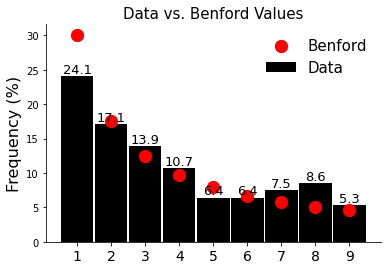

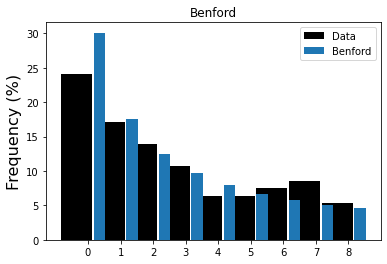

0.2550690257394217
random multiplying factor constant for all population data  = 0.2550690257394217 


observed counts = [58, 42, 17, 16, 15, 9, 13, 9, 8]
expected counts = [56, 33, 23, 18, 15, 13, 11, 10, 9] 

First Digit Probabilities:
1: observed: 0.310  expected: 0.301
2: observed: 0.225  expected: 0.176
3: observed: 0.091  expected: 0.125
4: observed: 0.086  expected: 0.097
5: observed: 0.080  expected: 0.079
6: observed: 0.048  expected: 0.067
7: observed: 0.070  expected: 0.058
8: observed: 0.048  expected: 0.051
9: observed: 0.043  expected: 0.046

Chi-squared Test Statistic = 6.119
Critical value at a P-value of 0.05 is 15.51.
Observed distribution matches expected distribution.


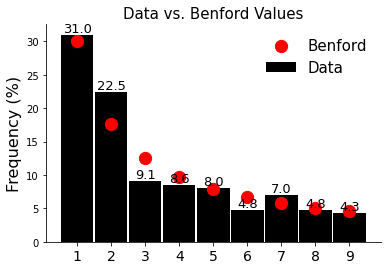

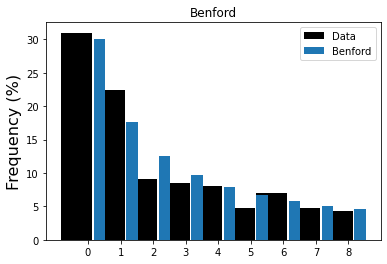

0.49543508709194095
random multiplying factor constant for all population data  = 0.49543508709194095 


observed counts = [54, 40, 17, 20, 24, 10, 8, 6, 8]
expected counts = [56, 33, 23, 18, 15, 13, 11, 10, 9] 

First Digit Probabilities:
1: observed: 0.289  expected: 0.301
2: observed: 0.214  expected: 0.176
3: observed: 0.091  expected: 0.125
4: observed: 0.107  expected: 0.097
5: observed: 0.128  expected: 0.079
6: observed: 0.053  expected: 0.067
7: observed: 0.043  expected: 0.058
8: observed: 0.032  expected: 0.051
9: observed: 0.043  expected: 0.046

Chi-squared Test Statistic = 11.965
Critical value at a P-value of 0.05 is 15.51.
Observed distribution matches expected distribution.


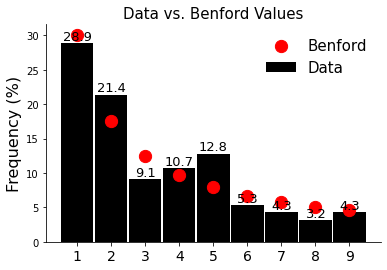

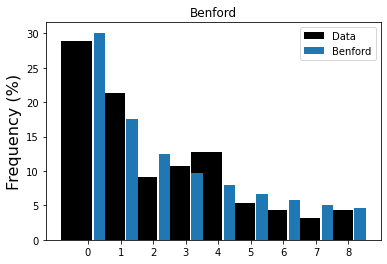

0.4494910647887381
random multiplying factor constant for all population data  = 0.4494910647887381 


observed counts = [51, 39, 17, 28, 18, 6, 7, 10, 11]
expected counts = [56, 33, 23, 18, 15, 13, 11, 10, 9] 

First Digit Probabilities:
1: observed: 0.273  expected: 0.301
2: observed: 0.209  expected: 0.176
3: observed: 0.091  expected: 0.125
4: observed: 0.150  expected: 0.097
5: observed: 0.096  expected: 0.079
6: observed: 0.032  expected: 0.067
7: observed: 0.037  expected: 0.058
8: observed: 0.053  expected: 0.051
9: observed: 0.059  expected: 0.046

Chi-squared Test Statistic = 14.926
Critical value at a P-value of 0.05 is 15.51.
Observed distribution matches expected distribution.


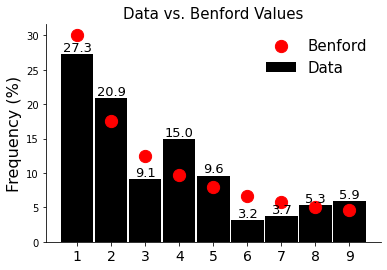

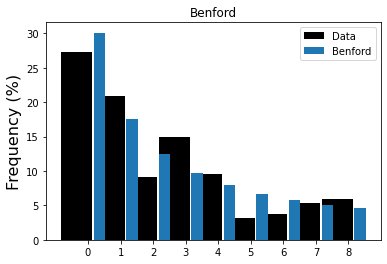

0.651592972722763
random multiplying factor constant for all population data  = 0.651592972722763 


observed counts = [53, 29, 32, 12, 16, 16, 16, 9, 4]
expected counts = [56, 33, 23, 18, 15, 13, 11, 10, 9] 

First Digit Probabilities:
1: observed: 0.283  expected: 0.301
2: observed: 0.155  expected: 0.176
3: observed: 0.171  expected: 0.125
4: observed: 0.064  expected: 0.097
5: observed: 0.086  expected: 0.079
6: observed: 0.086  expected: 0.067
7: observed: 0.086  expected: 0.058
8: observed: 0.048  expected: 0.051
9: observed: 0.021  expected: 0.046

Chi-squared Test Statistic = 12.077
Critical value at a P-value of 0.05 is 15.51.
Observed distribution matches expected distribution.


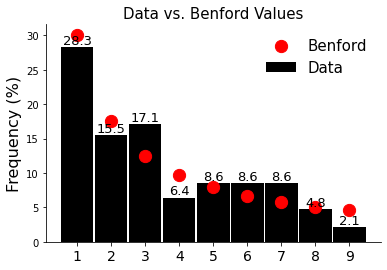

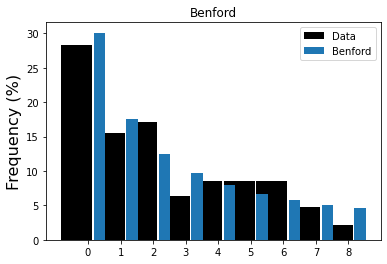

0.7887233511355132
random multiplying factor constant for all population data  = 0.7887233511355132 


observed counts = [45, 32, 22, 25, 10, 10, 14, 17, 12]
expected counts = [56, 33, 23, 18, 15, 13, 11, 10, 9] 

First Digit Probabilities:
1: observed: 0.241  expected: 0.301
2: observed: 0.171  expected: 0.176
3: observed: 0.118  expected: 0.125
4: observed: 0.134  expected: 0.097
5: observed: 0.053  expected: 0.079
6: observed: 0.053  expected: 0.067
7: observed: 0.075  expected: 0.058
8: observed: 0.091  expected: 0.051
9: observed: 0.064  expected: 0.046

Chi-squared Test Statistic = 14.034
Critical value at a P-value of 0.05 is 15.51.
Observed distribution matches expected distribution.


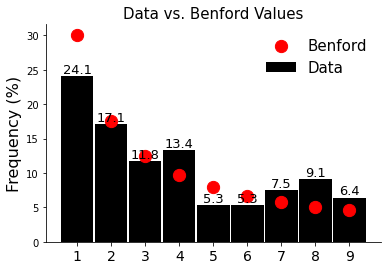

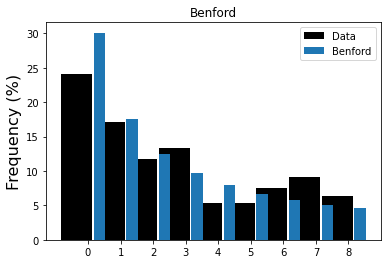

0.0938595867742349
random multiplying factor constant for all population data  = 0.0938595867742349 


observed counts = [53, 30, 22, 22, 18, 9, 9, 12, 12]
expected counts = [56, 33, 23, 18, 15, 13, 11, 10, 9] 

First Digit Probabilities:
1: observed: 0.283  expected: 0.301
2: observed: 0.160  expected: 0.176
3: observed: 0.118  expected: 0.125
4: observed: 0.118  expected: 0.097
5: observed: 0.096  expected: 0.079
6: observed: 0.048  expected: 0.067
7: observed: 0.048  expected: 0.058
8: observed: 0.064  expected: 0.051
9: observed: 0.064  expected: 0.046

Chi-squared Test Statistic = 4.960
Critical value at a P-value of 0.05 is 15.51.
Observed distribution matches expected distribution.


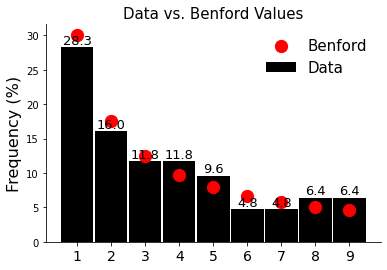

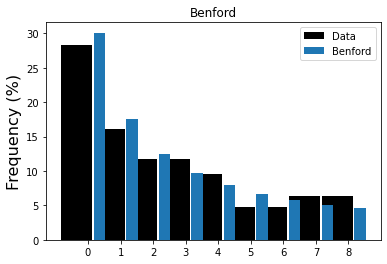

0.02834747652200631
random multiplying factor constant for all population data  = 0.02834747652200631 


observed counts = [61, 34, 25, 12, 16, 12, 9, 9, 9]
expected counts = [56, 33, 23, 18, 15, 13, 11, 10, 9] 

First Digit Probabilities:
1: observed: 0.326  expected: 0.301
2: observed: 0.182  expected: 0.176
3: observed: 0.134  expected: 0.125
4: observed: 0.064  expected: 0.097
5: observed: 0.086  expected: 0.079
6: observed: 0.064  expected: 0.067
7: observed: 0.048  expected: 0.058
8: observed: 0.048  expected: 0.051
9: observed: 0.048  expected: 0.046

Chi-squared Test Statistic = 3.258
Critical value at a P-value of 0.05 is 15.51.
Observed distribution matches expected distribution.


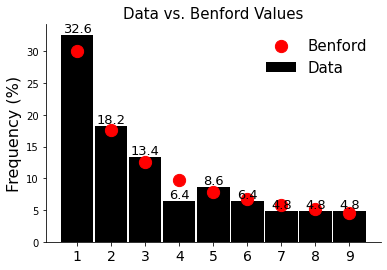

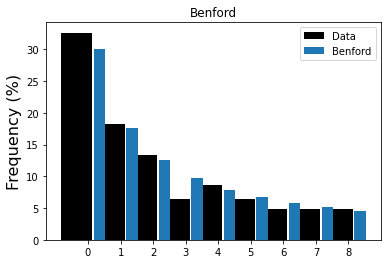

In [23]:
# generate random floating point values
from random import seed
from random import random
# seed random number generator
seed(1)
# generate random numbers between 0-1
for _ in range(10):
	value = random()
	print(value)
	print("generated random multiplying factor constant for all population data  = {}".format(value), "\n")
	pom = maindataunique.copy(deep=True)
	pom["population"] = maindataunique["population"] * value *10
	
	main(pom,str_population)





